In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/xAI-project-computer-vision

import sys
sys.path.insert(0,'/content/drive/My Drive/Github/xAI-project-computer-vision')

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Rc4yOY9-4nyo4PuPOLW54tnaNHAfWufd/Github/xAI-project-computer-vision


In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import random
import multiprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
import models
from utils import print_model_summary, get_available_device, move_to_device, seed_all

device = get_available_device()
print("Device:", device)

seed_all(42)

Device: cuda
Random seed 42 has been set.


In [ ]:
from datasets import calculate_mean_std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# Calculate mean and std for normalization
mean_train, std_train = calculate_mean_std(train_data)
mean_test, std_test = calculate_mean_std(test_data)

# Print mean and std
print(f'mean_train: {mean_train}')
print(f'std_train: {std_train}')
print(f'mean_test: {mean_test}')
print(f'std_test: {std_test}')

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
mean_train: [0.4914, 0.4822, 0.4465]
std_train: [0.247, 0.2435, 0.2616]
mean_test: [0.4942, 0.4851, 0.4504]
std_test: [0.2467, 0.2429, 0.2616]


In [ ]:
# Default hyperparameters

num_classes = 10

# number of samples per batch to load
batch_size = 64

# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count() if not torch.cuda.is_available() else 2
print(f'Number of workers: {num_workers}')

epochs = 10
lr = 0.001
l2 = 0 #0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = None #0.1 #None

# Data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_test, std_test)
])

Number of workers: 2


# Train simple custom CNNs

## Train simple custom CNN v1

In [ ]:
# Hyperparameters (optim_code: _9)
epochs = 20

In [ ]:
# Specify model
model = models.get_model('simple_convnet', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_9')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_001014' --optim_code '_9' --model_name 'simple_convnet' --batch_size 64 --num_workers 2

In [ ]:
# Hyperparamter (optim_code: _469)
lr = 0.01
epochs = 20

In [ ]:
# Specify model
model = models.get_model('simple_convnet', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

from datasets import prepare_data_loaders
train_dl, _ = prepare_data_loaders(num_classes, batch_size, num_workers, train_transform, test_transform)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=train_dl.__len__())

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet',
                batch_size=batch_size, num_workers=num_workers, epochs=epochs,
                lr_scheduler=lr_scheduler,
                loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
                train_transform=train_transform, test_transform=test_transform,
                optim_code='_469')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240125_235338' --optim_code '_469' --model_name 'simple_convnet' --batch_size 64 --num_workers 2

In [ ]:
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1 #None

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_test, std_test),
])

In [ ]:
# Specify model
model = models.get_model('simple_convnet', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]       18,496               True
├─MaxPool2d (pool)                       [64, 64, 8, 8]       [64, 64, 4, 4]       --                   --
├─Dropout (dropout)                      [64, 1024]           [64, 1024]           --                   --
├─Linear (fc1)        

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.2960
Epoch: 001/020 | Batch 121/625 | Loss: 1.7641
Epoch: 001/020 | Batch 241/625 | Loss: 1.6175
Epoch: 001/020 | Batch 361/625 | Loss: 1.7233
Epoch: 001/020 | Batch 481/625 | Loss: 1.7168
Epoch: 001/020 | Batch 601/625 | Loss: 1.6344
Epoch: 001/020   Train Loss: 1.6590 | Train Acc.: 39.31% | Validation Loss: 1.3879 | Validation Acc.: 50.02%
Validation loss decreased (inf --> 1.3879).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.5027
Epoch: 002/020 | Batch 121/625 | Loss: 1.5499
Epoch: 002/020 | Batch 241/625 | Loss: 1.3833
Epoch: 002/020 | Batch 361/625 | Loss: 1.2640
Epoch: 002/020 | Batch 481/625 | Loss: 1.2640
Epoch: 002/020 | Batch 601/625 | Loss: 1.4209
Epoch: 002/020   Train Loss: 1.3375 | Train Acc.: 51.80% | Validation Loss: 1.191

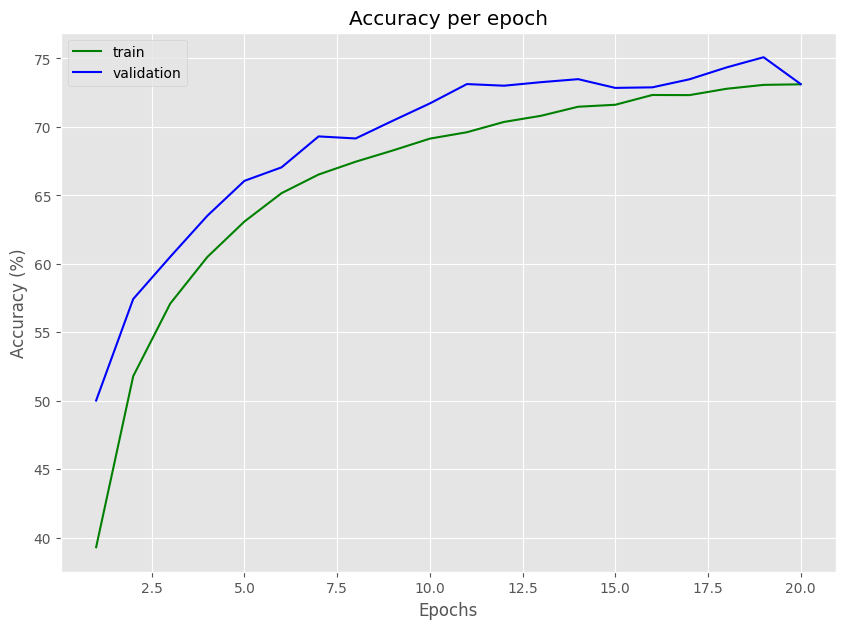

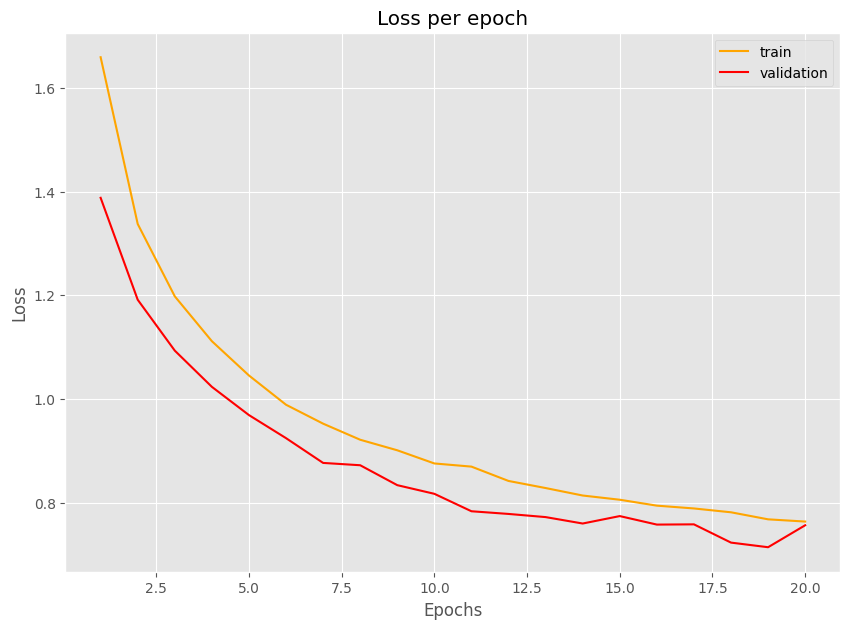

TRAINING FINISHED
CPU times: user 1min 48s, sys: 18.1 s, total: 2min 6s
Wall time: 8min 11s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet',
                batch_size=batch_size, num_workers=num_workers, epochs=epochs,
                lr_scheduler=lr_scheduler,
                loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
                train_transform=train_transform, test_transform=test_transform,
                optim_code='_1359')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_010422' --optim_code '_1359' --model_name 'simple_convnet' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]  

## Train simple custom CNN v2

In [ ]:
# Hyperparameters (optim_code: _135)
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('simple_convnet_v2', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNetV2 (SimpleConvNetV2)        [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 48, 32, 32]     1,344                True
├─Conv2d (conv2)                         [64, 48, 32, 32]     [64, 96, 32, 32]     41,568               True
├─MaxPool2d (pool)                       [64, 96, 32, 32]     [64, 96, 16, 16]     --                   --
├─Dropout (dropout)                      [64, 96, 16, 16]     [64, 96, 16, 16]     --                   --
├─Conv2d (conv3)                         [64, 96, 16, 16]     [64, 192, 16, 16]    166,080              True
├─Conv2d (conv4)                         [64, 192, 16, 16]    [64, 256, 16, 16]    442,624              True
├─MaxPool2d (pool)                       [64, 256, 16, 16]    [64, 256, 8, 8]      --                   --
├─Dropout (dropout) 

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/010 | Batch 001/625 | Loss: 2.2995
Epoch: 001/010 | Batch 121/625 | Loss: 1.9357
Epoch: 001/010 | Batch 241/625 | Loss: 1.6638
Epoch: 001/010 | Batch 361/625 | Loss: 1.8112
Epoch: 001/010 | Batch 481/625 | Loss: 1.7896
Epoch: 001/010 | Batch 601/625 | Loss: 1.5778
Epoch: 001/010   Train Loss: 1.7175 | Train Acc.: 35.58% | Validation Loss: 1.3452 | Validation Acc.: 50.98%
Validation loss decreased (inf --> 1.3452).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/010 | Batch 001/625 | Loss: 1.4722
Epoch: 002/010 | Batch 121/625 | Loss: 1.5778
Epoch: 002/010 | Batch 241/625 | Loss: 1.2948
Epoch: 002/010 | Batch 361/625 | Loss: 1.1124
Epoch: 002/010 | Batch 481/625 | Loss: 1.2711
Epoch: 002/010 | Batch 601/625 | Loss: 1.2076
Epoch: 002/010   Train Loss: 1.2899 | Train Acc.: 53.69% | Validation Loss: 1.100

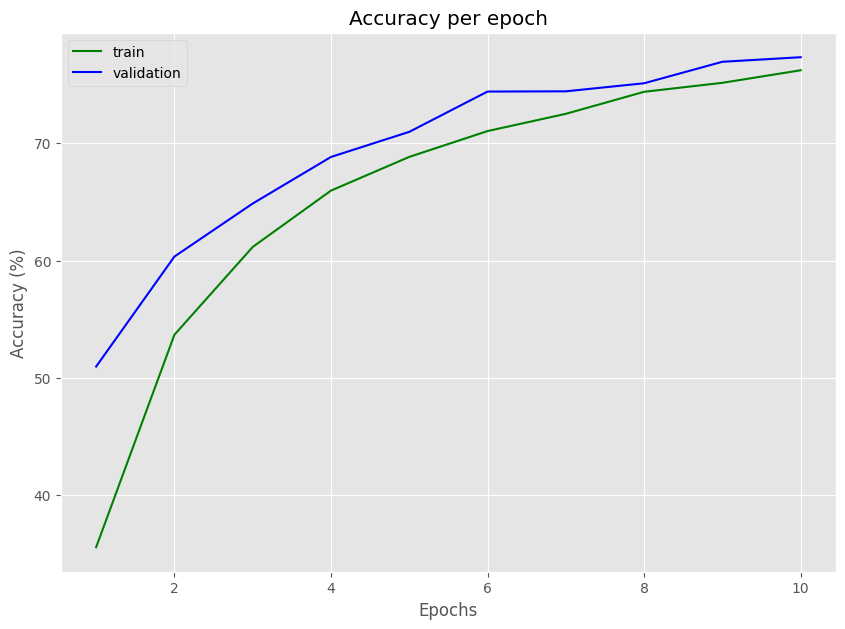

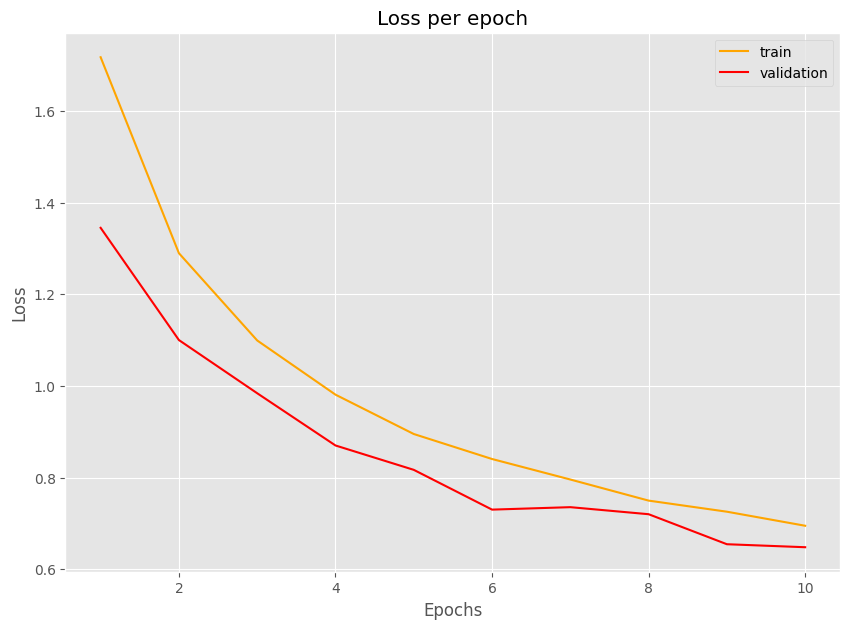

TRAINING FINISHED
CPU times: user 1min 43s, sys: 10.1 s, total: 1min 54s
Wall time: 4min 39s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet_v2',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_135')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_011648' --optim_code '_135' --model_name 'simple_convnet_v2' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNetV2 (SimpleConvNetV2)        [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 48, 32, 32]     1,344                True
├─Conv2d (conv2)                         [64, 48, 32, 32]     [64, 96, 32, 32]     41,568               True
├─MaxPool2d (pool)                       [64, 96, 32, 32]     [64, 96, 16, 16]     --                   --
├─Dropout (dropout)                      [64, 96, 16, 16]     [64, 96, 16, 16]     --                   --
├─Conv2d (conv3)                         [64, 96, 16, 16]     [64, 192, 16, 16

# Train deeper custom CNNs (based on ResNet)

## Train simplified custom ResNet

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/010 | Batch 001/625 | Loss: 3.5513
Epoch: 001/010 | Batch 121/625 | Loss: 1.4183
Epoch: 001/010 | Batch 241/625 | Loss: 1.6588
Epoch: 001/010 | Batch 361/625 | Loss: 1.3925
Epoch: 001/010 | Batch 481/625 | Loss: 1.2968
Epoch: 001/010 | Batch 601/625 | Loss: 0.9541
Epoch: 001/010   Train Loss: 1.4588 | Train Acc.: 49.67% | Validation Loss: 0.9495 | Validation Acc.: 66.51%
Validation loss decreased (inf --> 0.9495).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/010 | Batch 001/625 | Loss: 1.0112
Epoch: 002/010 | Batch 121/625 | Loss: 1.0368
Epoch: 002/010 | Batch 241/625 | Loss: 0.9017
Epoch: 002/010 | Batch 361/625 | Loss: 0.6610
Epoch: 002/010 | Batch 481/625 | Loss: 0.8210
Epoch: 002/010 | Batch 601/625 | Loss: 0.6427
Epoch: 002/010   Train Loss: 0.8108 | Train Acc.: 72.26% | Validation Loss: 0.767

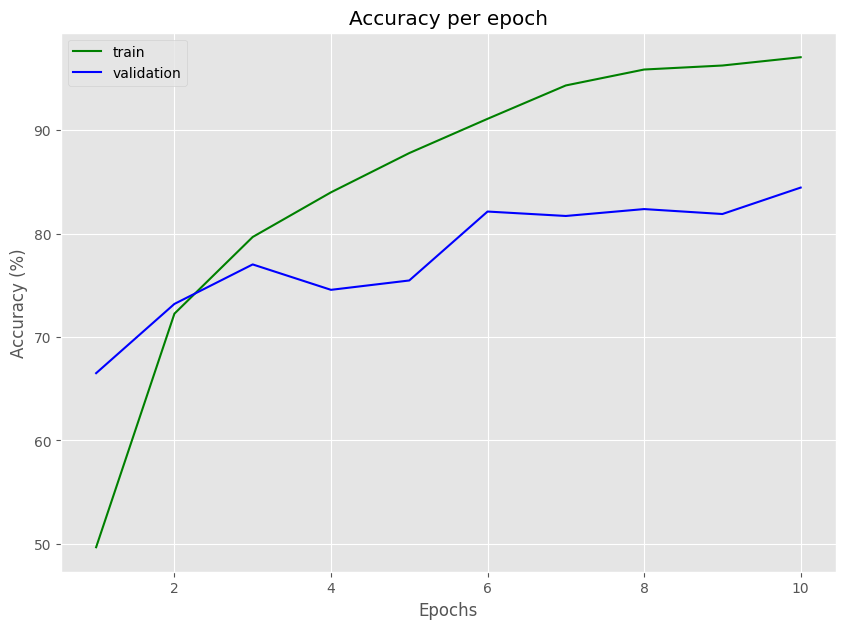

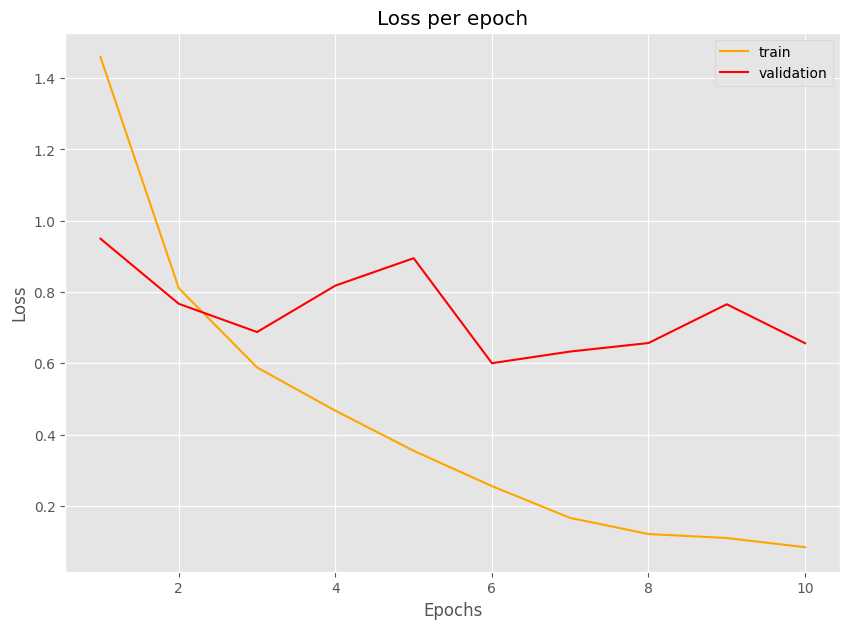

TRAINING FINISHED
CPU times: user 2min 59s, sys: 9.85 s, total: 3min 9s
Wall time: 4min 21s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform)

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_012640' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 3.5513
Epoch: 001/020 | Batch 121/625 | Loss: 1.3813
Epoch: 001/020 | Batch 241/625 | Loss: 1.6069
Epoch: 001/020 | Batch 361/625 | Loss: 1.3491
Epoch: 001/020 | Batch 481/625 | Loss: 1.3502
Epoch: 001/020 | Batch 601/625 | Loss: 0.8866
Epoch: 001/020   Train Loss: 1.4636 | Train Acc.: 50.17% | Validation Loss: 0.9483 | Validation Acc.: 66.58%
Validation loss decreased (inf --> 0.9483).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.0463
Epoch: 002/020 | Batch 121/625 | Loss: 1.0677
Epoch: 002/020 | Batch 241/625 | Loss: 0.8762
Epoch: 002/020 | Batch 361/625 | Loss: 0.5555
Epoch: 002/020 | Batch 481/625 | Loss: 0.7703
Epoch: 002/020 | Batch 601/625 | Loss: 0.5999
Epoch: 002/020   Train Loss: 0.8184 | Train Acc.: 71.82% | Validation Loss: 0.810

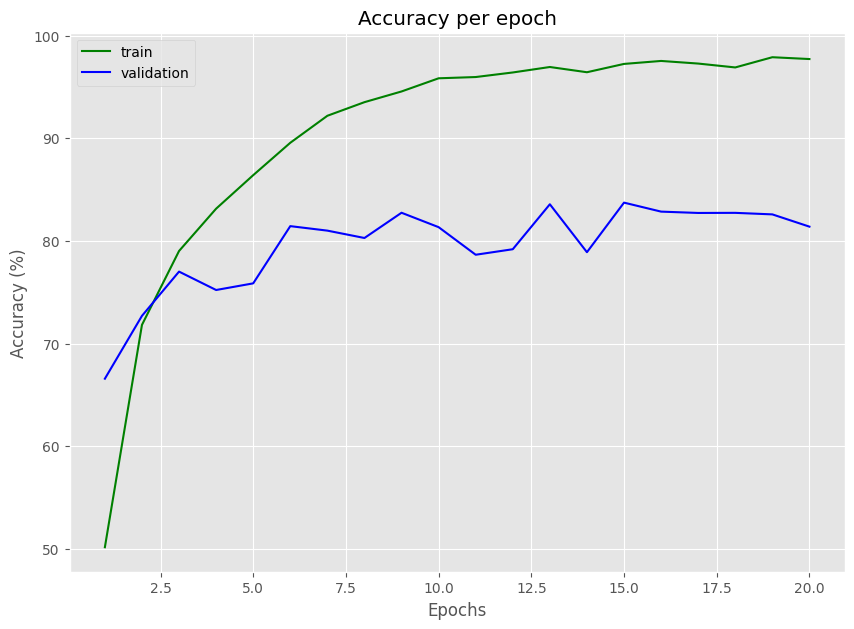

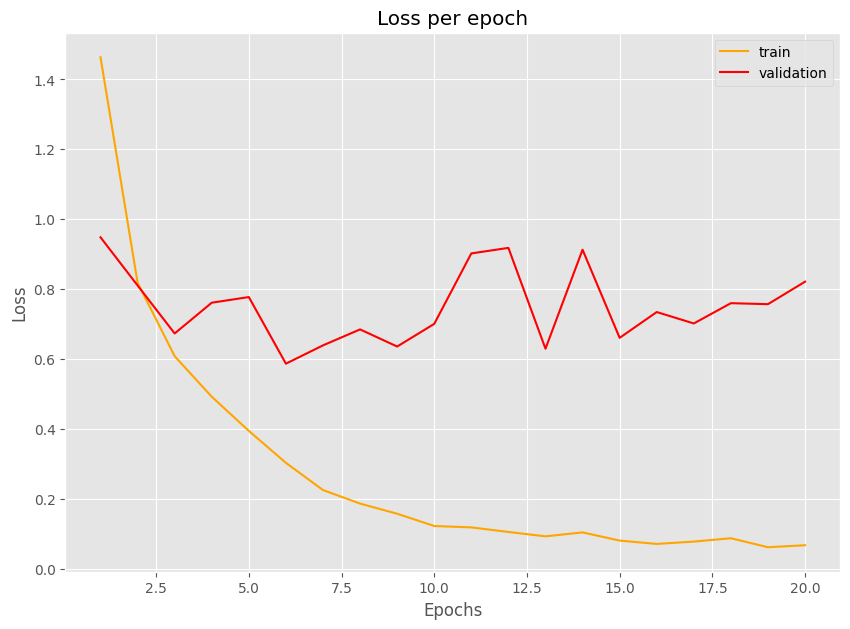

TRAINING FINISHED
CPU times: user 6min 12s, sys: 18.2 s, total: 6min 30s
Wall time: 8min 48s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_013356' --optim_code '_359' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# TOP
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.5795
Epoch: 001/020 | Batch 121/625 | Loss: 1.6709
Epoch: 001/020 | Batch 241/625 | Loss: 1.6580
Epoch: 001/020 | Batch 361/625 | Loss: 1.4589
Epoch: 001/020 | Batch 481/625 | Loss: 1.4064
Epoch: 001/020 | Batch 601/625 | Loss: 1.1186
Epoch: 001/020   Train Loss: 1.5920 | Train Acc.: 45.53% | Validation Loss: 1.2038 | Validation Acc.: 60.66%
Validation loss decreased (inf --> 1.2038).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.3845
Epoch: 002/020 | Batch 121/625 | Loss: 1.3395
Epoch: 002/020 | Batch 241/625 | Loss: 1.2311
Epoch: 002/020 | Batch 361/625 | Loss: 0.7003
Epoch: 002/020 | Batch 481/625 | Loss: 0.8353
Epoch: 002/020 | Batch 601/625 | Loss: 0.8130
Epoch: 002/020   Train Loss: 0.9773 | Train Acc.: 66.29% | Validation Loss: 0.853

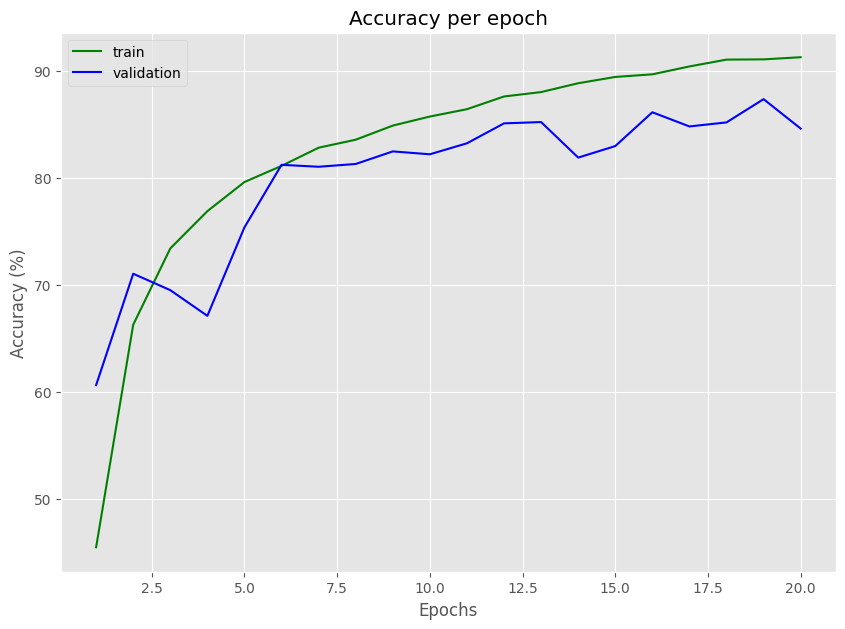

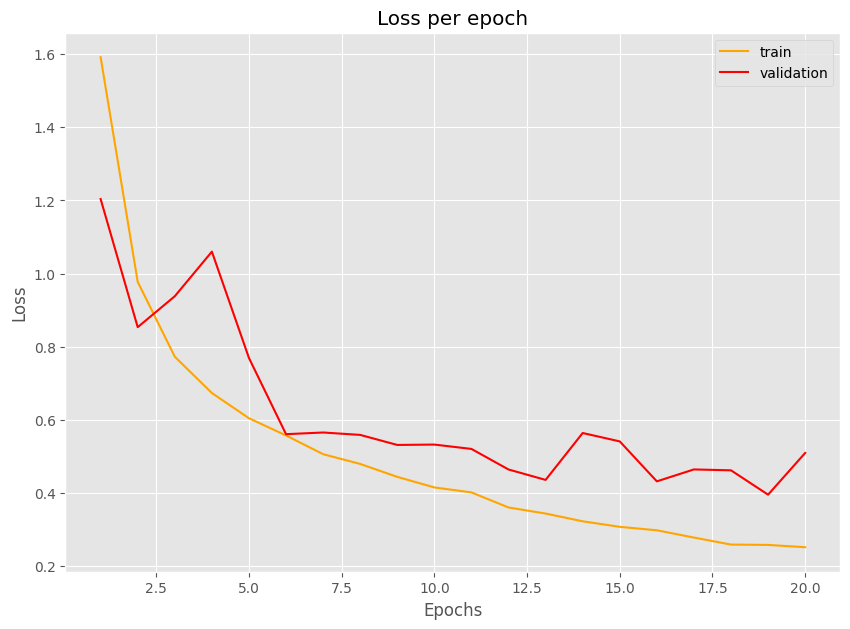

TRAINING FINISHED
CPU times: user 5min 24s, sys: 19.6 s, total: 5min 44s
Wall time: 10min 46s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_014705' --optim_code '_1359' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _359d)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.6232
Epoch: 001/020 | Batch 121/625 | Loss: 2.4855
Epoch: 001/020 | Batch 241/625 | Loss: 2.1105
Epoch: 001/020 | Batch 361/625 | Loss: 2.1878
Epoch: 001/020 | Batch 481/625 | Loss: 2.2269
Epoch: 001/020 | Batch 601/625 | Loss: 2.3936
Epoch: 001/020   Train Loss: 2.3514 | Train Acc.: 19.65% | Validation Loss: 2.0389 | Validation Acc.: 25.12%
Validation loss decreased (inf --> 2.0389).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 2.2594
Epoch: 002/020 | Batch 121/625 | Loss: 2.2963
Epoch: 002/020 | Batch 241/625 | Loss: 2.1392
Epoch: 002/020 | Batch 361/625 | Loss: 1.9821
Epoch: 002/020 | Batch 481/625 | Loss: 1.8736
Epoch: 002/020 | Batch 601/625 | Loss: 1.8739
Epoch: 002/020   Train Loss: 2.0203 | Train Acc.: 29.14% | Validation Loss: 1.901

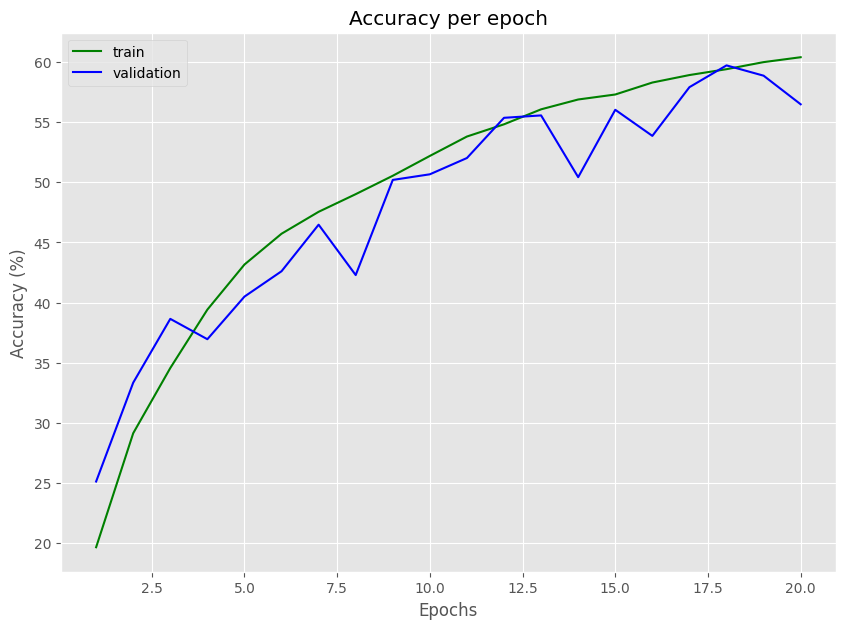

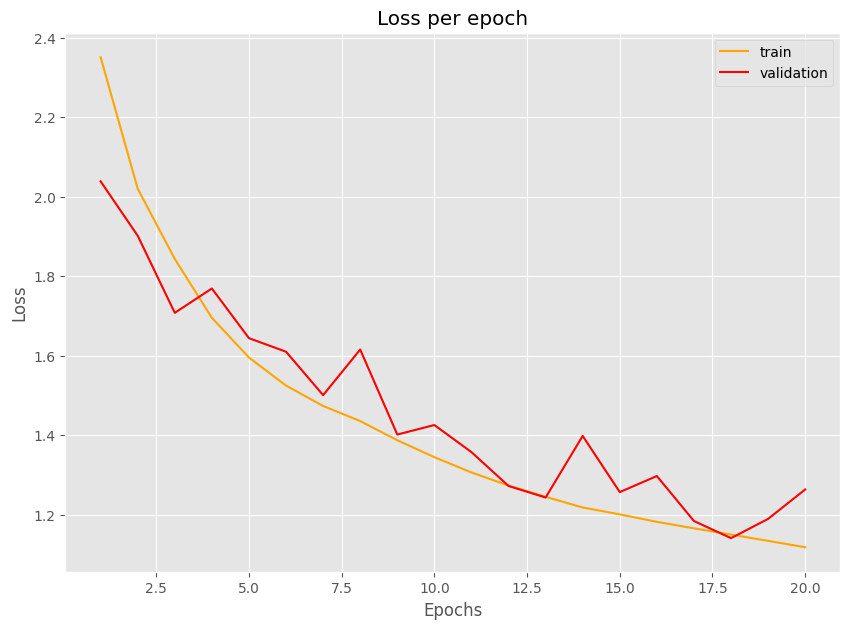

TRAINING FINISHED
CPU times: user 6min 44s, sys: 18.8 s, total: 7min 3s
Wall time: 35min 12s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359d')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_044207' --optim_code '_359d' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

## Train custom ResNet18

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/010 | Batch 001/625 | Loss: 2.4584
Epoch: 001/010 | Batch 121/625 | Loss: 1.4194
Epoch: 001/010 | Batch 241/625 | Loss: 1.4366
Epoch: 001/010 | Batch 361/625 | Loss: 1.5587
Epoch: 001/010 | Batch 481/625 | Loss: 1.3005
Epoch: 001/010 | Batch 601/625 | Loss: 1.1713
Epoch: 001/010   Train Loss: 1.3994 | Train Acc.: 48.94% | Validation Loss: 1.1892 | Validation Acc.: 58.19%
Validation loss decreased (inf --> 1.1892).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/010 | Batch 001/625 | Loss: 1.1542
Epoch: 002/010 | Batch 121/625 | Loss: 1.1809
Epoch: 002/010 | Batch 241/625 | Loss: 1.1095
Epoch: 002/010 | Batch 361/625 | Loss: 0.7576
Epoch: 002/010 | Batch 481/625 | Loss: 0.9683
Epoch: 002/010 | Batch 601/625 | Loss: 0.7128
Epoch: 002/010   Train Loss: 0.9188 | Train Acc.: 67.67% | Validation Loss: 0.802

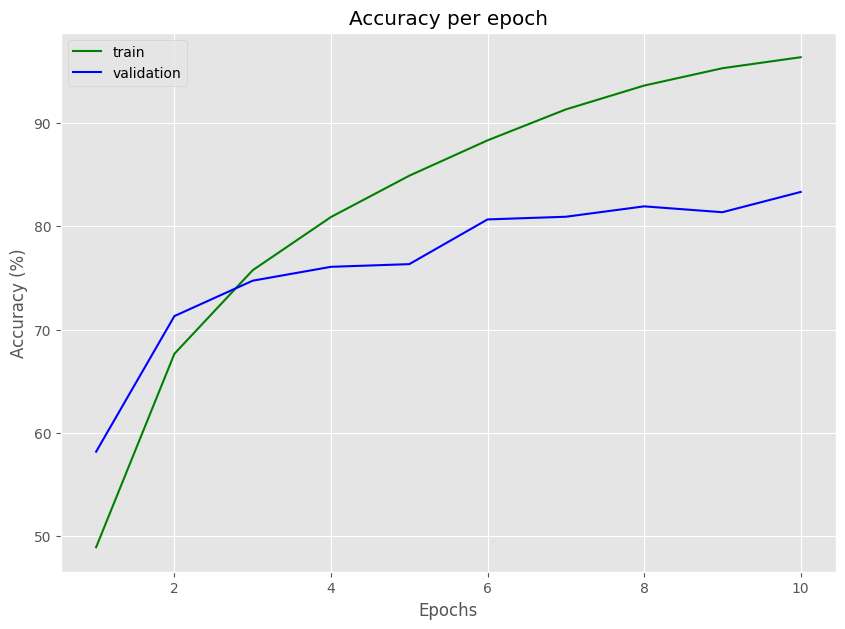

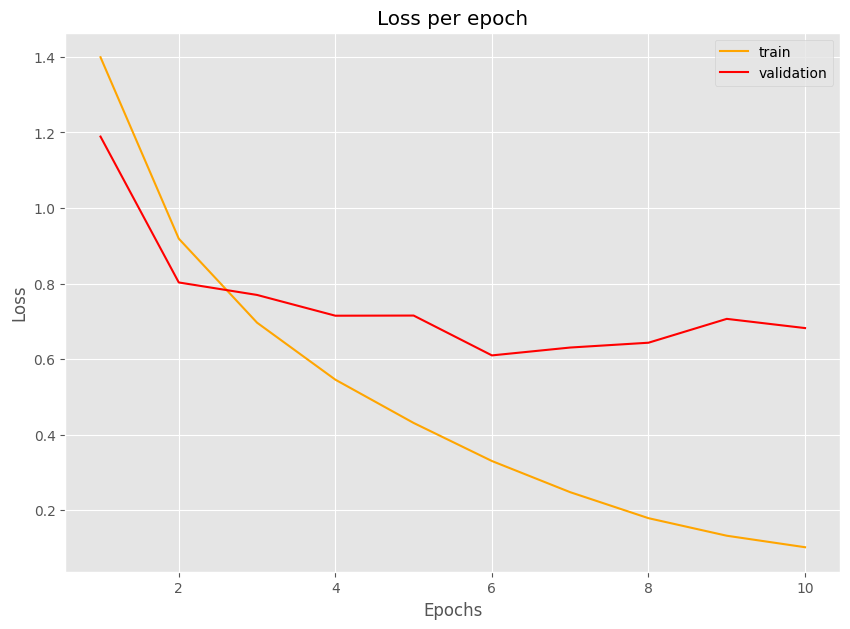

TRAINING FINISHED
CPU times: user 6min 28s, sys: 12.1 s, total: 6min 40s
Wall time: 8min


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform)

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_021006' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# TOP
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.4731
Epoch: 001/020 | Batch 121/625 | Loss: 1.5080
Epoch: 001/020 | Batch 241/625 | Loss: 1.5970
Epoch: 001/020 | Batch 361/625 | Loss: 1.7279
Epoch: 001/020 | Batch 481/625 | Loss: 1.5396
Epoch: 001/020 | Batch 601/625 | Loss: 1.2349
Epoch: 001/020   Train Loss: 1.5378 | Train Acc.: 43.21% | Validation Loss: 1.2302 | Validation Acc.: 54.65%
Validation loss decreased (inf --> 1.2302).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.2868
Epoch: 002/020 | Batch 121/625 | Loss: 1.3548
Epoch: 002/020 | Batch 241/625 | Loss: 1.2702
Epoch: 002/020 | Batch 361/625 | Loss: 0.9425
Epoch: 002/020 | Batch 481/625 | Loss: 1.1907
Epoch: 002/020 | Batch 601/625 | Loss: 0.9310
Epoch: 002/020   Train Loss: 1.0768 | Train Acc.: 61.38% | Validation Loss: 1.074

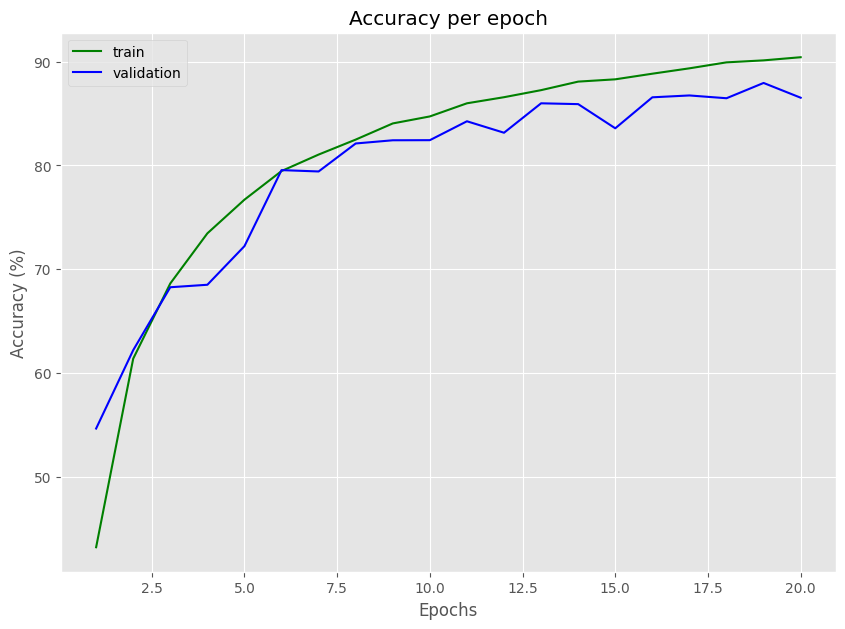

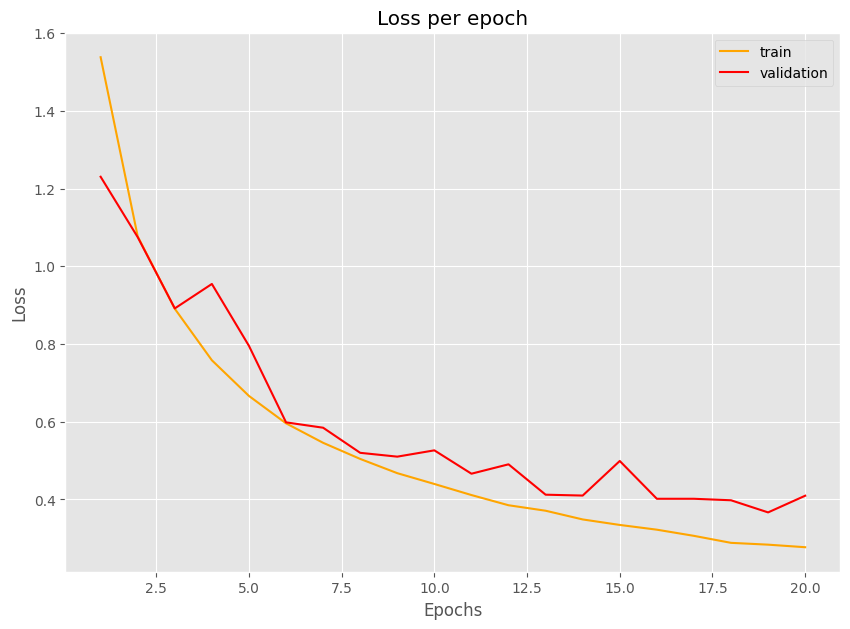

TRAINING FINISHED
CPU times: user 12min 39s, sys: 24.1 s, total: 13min 3s
Wall time: 16min 37s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_022231' --optim_code '_1359' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _359b)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.4145
Epoch: 001/020 | Batch 121/625 | Loss: 1.9316
Epoch: 001/020 | Batch 241/625 | Loss: 1.8781
Epoch: 001/020 | Batch 361/625 | Loss: 2.1022
Epoch: 001/020 | Batch 481/625 | Loss: 1.8575
Epoch: 001/020 | Batch 601/625 | Loss: 1.8958
Epoch: 001/020   Train Loss: 1.9358 | Train Acc.: 27.54% | Validation Loss: 1.8042 | Validation Acc.: 32.53%
Validation loss decreased (inf --> 1.8042).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.8297
Epoch: 002/020 | Batch 121/625 | Loss: 1.7657
Epoch: 002/020 | Batch 241/625 | Loss: 1.7368
Epoch: 002/020 | Batch 361/625 | Loss: 1.6201
Epoch: 002/020 | Batch 481/625 | Loss: 1.8284
Epoch: 002/020 | Batch 601/625 | Loss: 1.5040
Epoch: 002/020   Train Loss: 1.6855 | Train Acc.: 37.84% | Validation Loss: 1.564

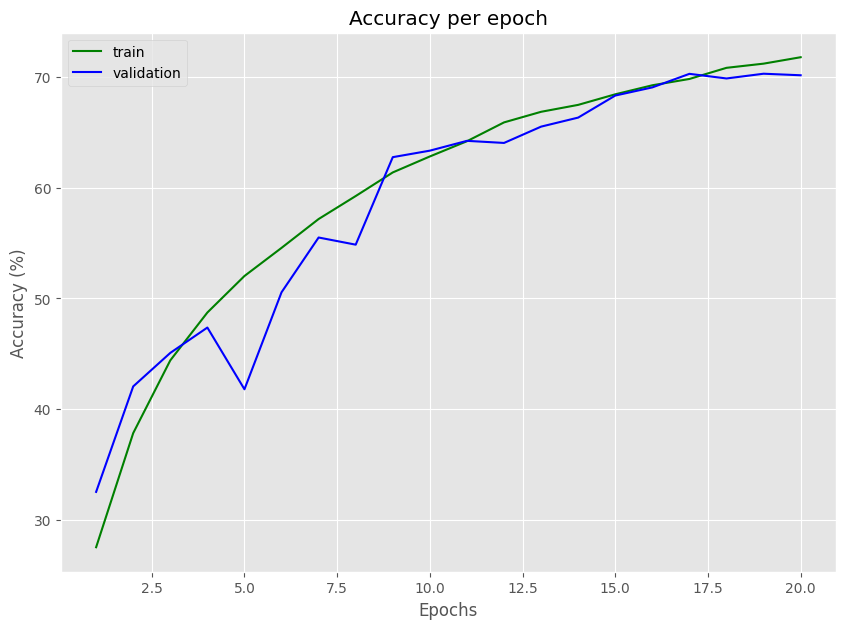

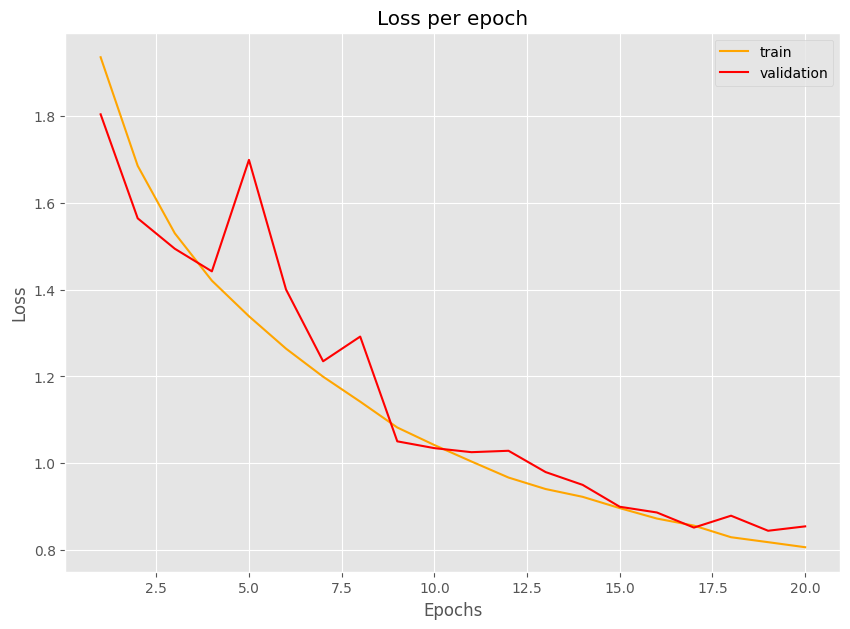

TRAINING FINISHED
CPU times: user 9min 36s, sys: 22 s, total: 9min 58s
Wall time: 31min 31s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359b')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_052346' --optim_code '_359b' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _359c)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/010 | Batch 001/625 | Loss: 2.3916
Epoch: 001/010 | Batch 121/625 | Loss: 1.4844
Epoch: 001/010 | Batch 241/625 | Loss: 1.4605
Epoch: 001/010 | Batch 361/625 | Loss: 1.4395
Epoch: 001/010 | Batch 481/625 | Loss: 1.3534
Epoch: 001/010 | Batch 601/625 | Loss: 1.1007
Epoch: 001/010   Train Loss: 1.4176 | Train Acc.: 47.84% | Validation Loss: 1.4377 | Validation Acc.: 51.40%
Validation loss decreased (inf --> 1.4377).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/010 | Batch 001/625 | Loss: 1.1223
Epoch: 002/010 | Batch 121/625 | Loss: 1.0790
Epoch: 002/010 | Batch 241/625 | Loss: 1.1844
Epoch: 002/010 | Batch 361/625 | Loss: 0.7337
Epoch: 002/010 | Batch 481/625 | Loss: 0.8837
Epoch: 002/010 | Batch 601/625 | Loss: 0.7003
Epoch: 002/010   Train Loss: 0.9140 | Train Acc.: 67.64% | Validation Loss: 0.987

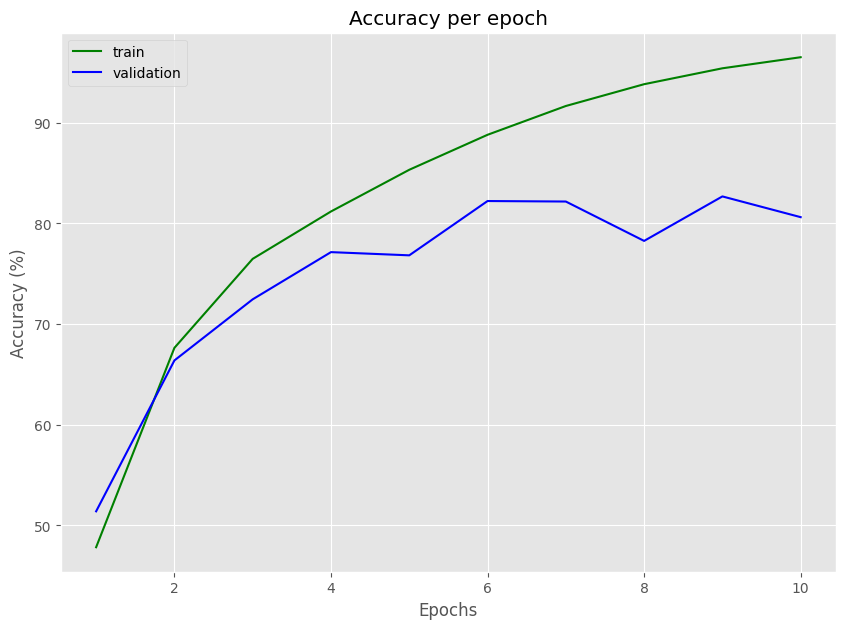

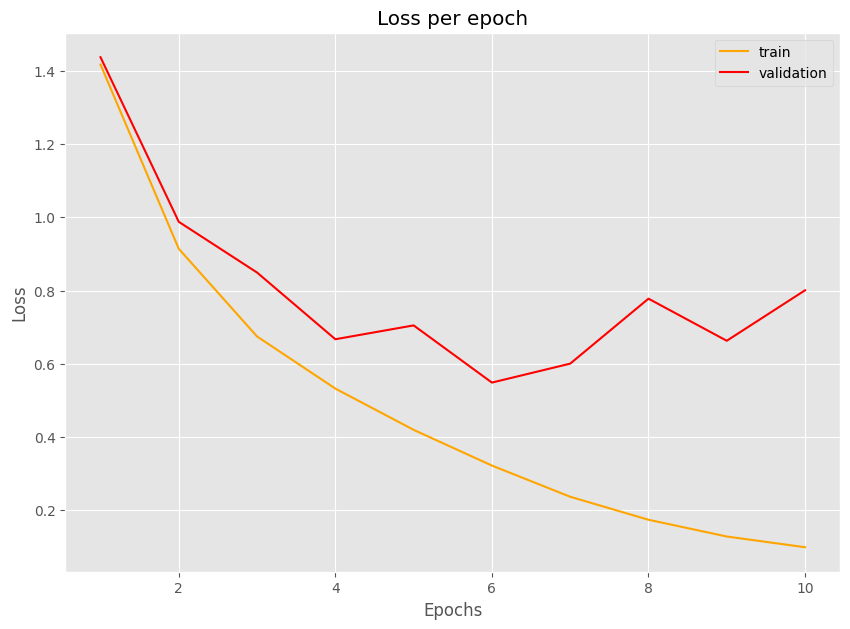

TRAINING FINISHED
CPU times: user 6min 31s, sys: 10.9 s, total: 6min 42s
Wall time: 7min 47s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359c')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_060920' --optim_code '_359c' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _359d)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.4023
Epoch: 001/020 | Batch 121/625 | Loss: 2.1758
Epoch: 001/020 | Batch 241/625 | Loss: 2.0142
Epoch: 001/020 | Batch 361/625 | Loss: 2.2503
Epoch: 001/020 | Batch 481/625 | Loss: 2.0333
Epoch: 001/020 | Batch 601/625 | Loss: 2.1098
Epoch: 001/020   Train Loss: 2.1052 | Train Acc.: 21.31% | Validation Loss: 1.9595 | Validation Acc.: 27.80%
Validation loss decreased (inf --> 1.9595).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 2.0320
Epoch: 002/020 | Batch 121/625 | Loss: 1.9891
Epoch: 002/020 | Batch 241/625 | Loss: 1.9628
Epoch: 002/020 | Batch 361/625 | Loss: 1.8940
Epoch: 002/020 | Batch 481/625 | Loss: 1.9808
Epoch: 002/020 | Batch 601/625 | Loss: 1.7459
Epoch: 002/020   Train Loss: 1.8922 | Train Acc.: 30.38% | Validation Loss: 1.848

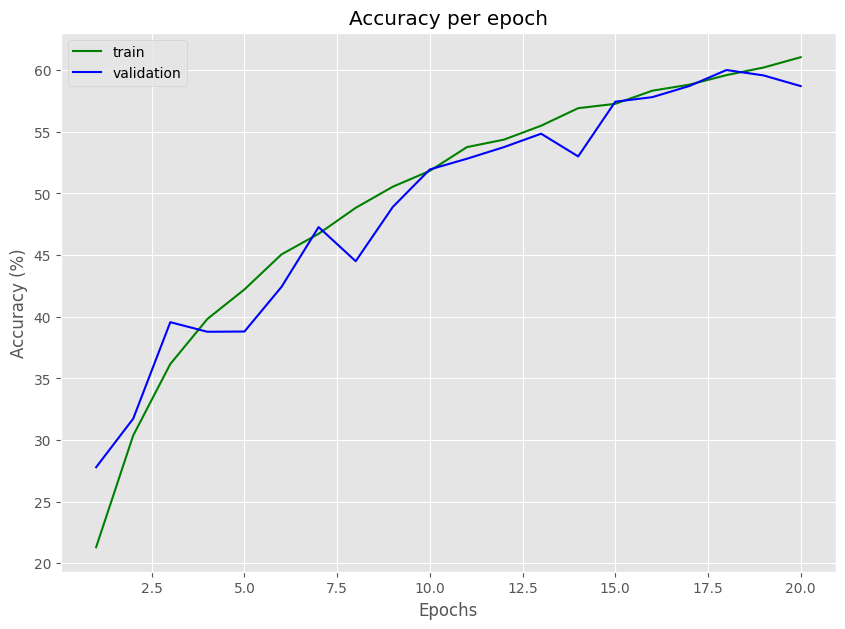

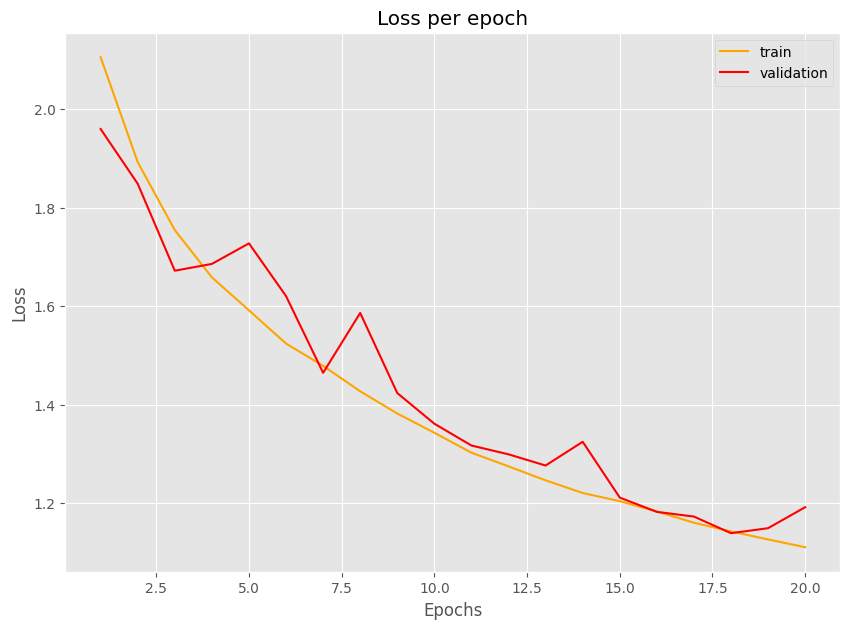

TRAINING FINISHED
CPU times: user 9min 42s, sys: 22.5 s, total: 10min 4s
Wall time: 38min 16s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359d')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_062655' --optim_code '_359d' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

## Train custom ResNet50

In [ ]:
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet50_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    └─Bottleneck (0)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     4,096                True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet50_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359')


Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.2995
Epoch: 001/020 | Batch 121/625 | Loss: 1.6164
Epoch: 001/020 | Batch 241/625 | Loss: 1.8905
Epoch: 001/020 | Batch 361/625 | Loss: 1.6299
Epoch: 001/020 | Batch 481/625 | Loss: 1.6466
Epoch: 001/020 | Batch 601/625 | Loss: 1.4166
Epoch: 001/020   Train Loss: 1.6373 | Train Acc.: 40.23% | Validation Loss: 1.2661 | Validation Acc.: 53.32%
Validation loss decreased (inf --> 1.2661).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.2869
Epoch: 002/020 | Batch 121/625 | Loss: 1.3747
Epoch: 002/020 | Batch 241/625 | Loss: 1.5424
Epoch: 002/020 | Batch 361/625 | Loss: 1.0655
Epoch: 002/020 | Batch 481/625 | Loss: 1.3606
Epoch: 002/020 | Batch 601/625 | Loss: 1.0338
Epoch: 002/020   Train Loss: 1.1678 | Train Acc.: 57.88% | Validation Loss: 1.066

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20231207_093202' --optim_code '_1359' --model_name 'resnet50_custom' --batch_size 64 --num_workers 2

In [ ]:
# Hyperparameters (optim_code: _12359)
epochs = 20
lr = 0.0001
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet50_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet50_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_12359')


In [ ]:
!python test.py --num_classes 10 --cp_datetime '20231207_093202' --optim_code '_12359' --model_name 'resnet50_custom' --batch_size 64 --num_workers 2

In [ ]:
# Hyperparameters (optim_code: _359b)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet50_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet50_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_359b')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20231207_093202' --optim_code '_359b' --model_name 'resnet50_custom' --batch_size 64 --num_workers 2

In [ ]:
# Hyperparameters (optim_code: _359c)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet50_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    └─Bottleneck (0)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     4,096                True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba